In [1]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from scipy.stats import pearsonr
import pmdarima as pm

In [2]:
# Configure pandas display options for better readability of DataFrame outputs
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_rows = 10  # Limit the number of rows displayed
pd.options.display.float_format = "{:.2f}".format  # Format floats to 2 decimal places

In [3]:
# Function to load data
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        if data.empty:
            raise ValueError("The dataset is empty.")
        print("Dataset loaded successfully.")
        return data
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        exit()

# Load dataset
data = load_data('web_data.csv')

Dataset loaded successfully.


In [4]:
# Assign the first row as column headers and reset the DataFrame index
def clean_data(df):
    df.columns = df.iloc[0]  # grab the first row for the header
    df = df[1:].reset_index(drop=True)  # exclude the original first row & ensure the DataFrame index is reset
    return df

data = clean_data(data)

In [5]:
# Data overview
print("DATA OVERVIEW:")
print(f"\n{data.head()}")
print(f"\n----Column Info:----\n{data.info()}")
print(f"\n----Summary Statistics:----\n{data.describe()}")
print(f"\n----Missing values:----\n{data.isnull().sum()}")

DATA OVERVIEW:

0 Session primary channel group (Default channel group)  \
0                                             Direct      
1                                     Organic Social      
2                                             Direct      
3                                     Organic Social      
4                                     Organic Social      

0 Date + hour (YYYYMMDDHH) Users Sessions Engaged sessions  \
0               2024041623   237      300              144   
1               2024041719   208      267              132   
2               2024041723   188      233              115   
3               2024041718   187      256              125   
4               2024041720   175      221              112   

0 Average engagement time per session Engaged sessions per user  \
0                  47.526666666666700        0.6075949367088610   
1                   32.09737827715360        0.6346153846153850   
2                   39.93991416309010        0.61170212

In [6]:
# Validate if necessary columns exist
required_columns = ["Date + hour (YYYYMMDDHH)", "Users", "Sessions"]
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"Missing required columns: {missing_columns}")

# Convert date column into datetime format
data["Date + hour (YYYYMMDDHH)"] = pd.to_datetime(
    data["Date + hour (YYYYMMDDHH)"], format="%Y%m%d%H", errors="coerce"
)

# Drop rows with invalid datetime entries
data = data.dropna(subset=["Date + hour (YYYYMMDDHH)"])

# Convert numeric columns to appropriate data types
def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    return df

# Convert necessary columns
numeric_columns = ['Users', 'Sessions']
data = convert_to_numeric(data, numeric_columns)

# Group data by date and aggregate users and sessions
grouped_data = data.groupby("Date + hour (YYYYMMDDHH)", as_index=False).agg(
    {"Users": "sum", "Sessions": "sum"}
)

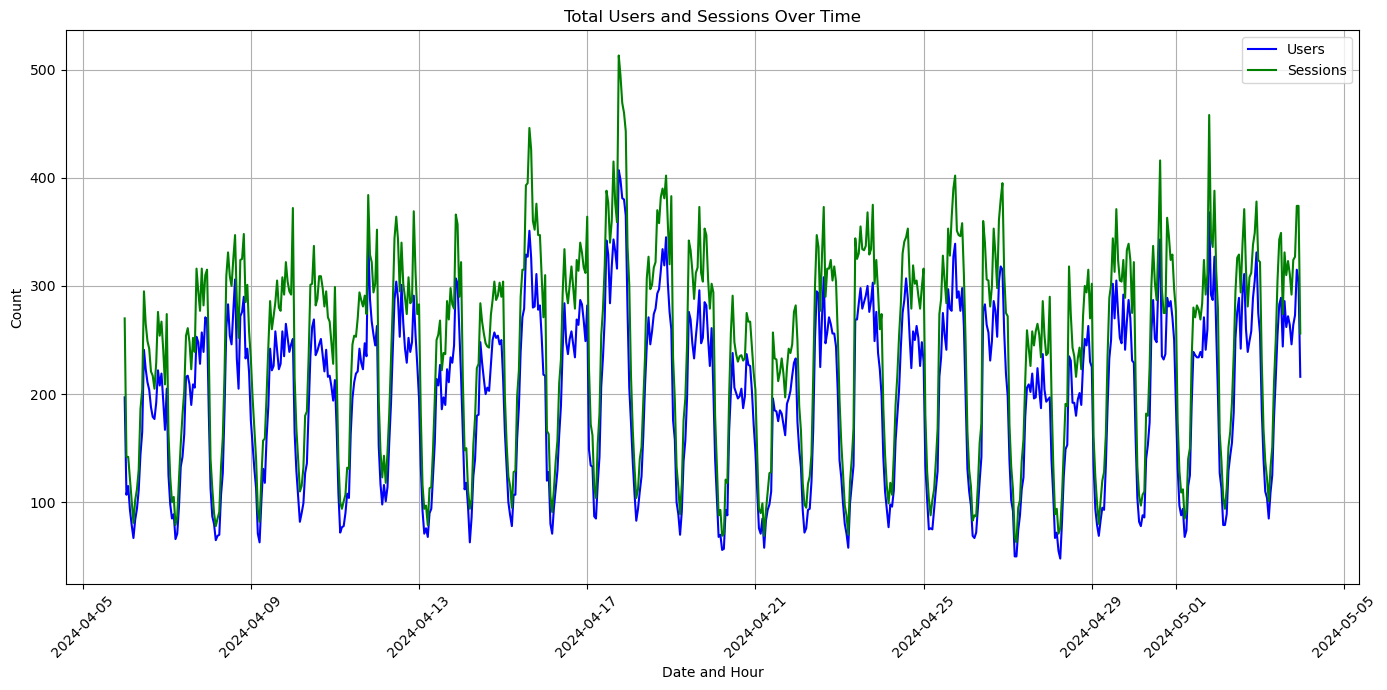

In [7]:
# Ensure the datetime column is the index
if "Date + hour (YYYYMMDDHH)" in grouped_data.columns:
    grouped_data.set_index("Date + hour (YYYYMMDDHH)", inplace=True)

# Plotting the aggregated users and sessions over time
plt.figure(figsize=(14, 7))
plt.plot(grouped_data.index, grouped_data['Users'], label='Users', color='blue')
plt.plot(grouped_data.index, grouped_data['Sessions'], label='Sessions', color='green')
plt.title('Total Users and Sessions Over Time')
plt.xlabel('Date and Hour')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

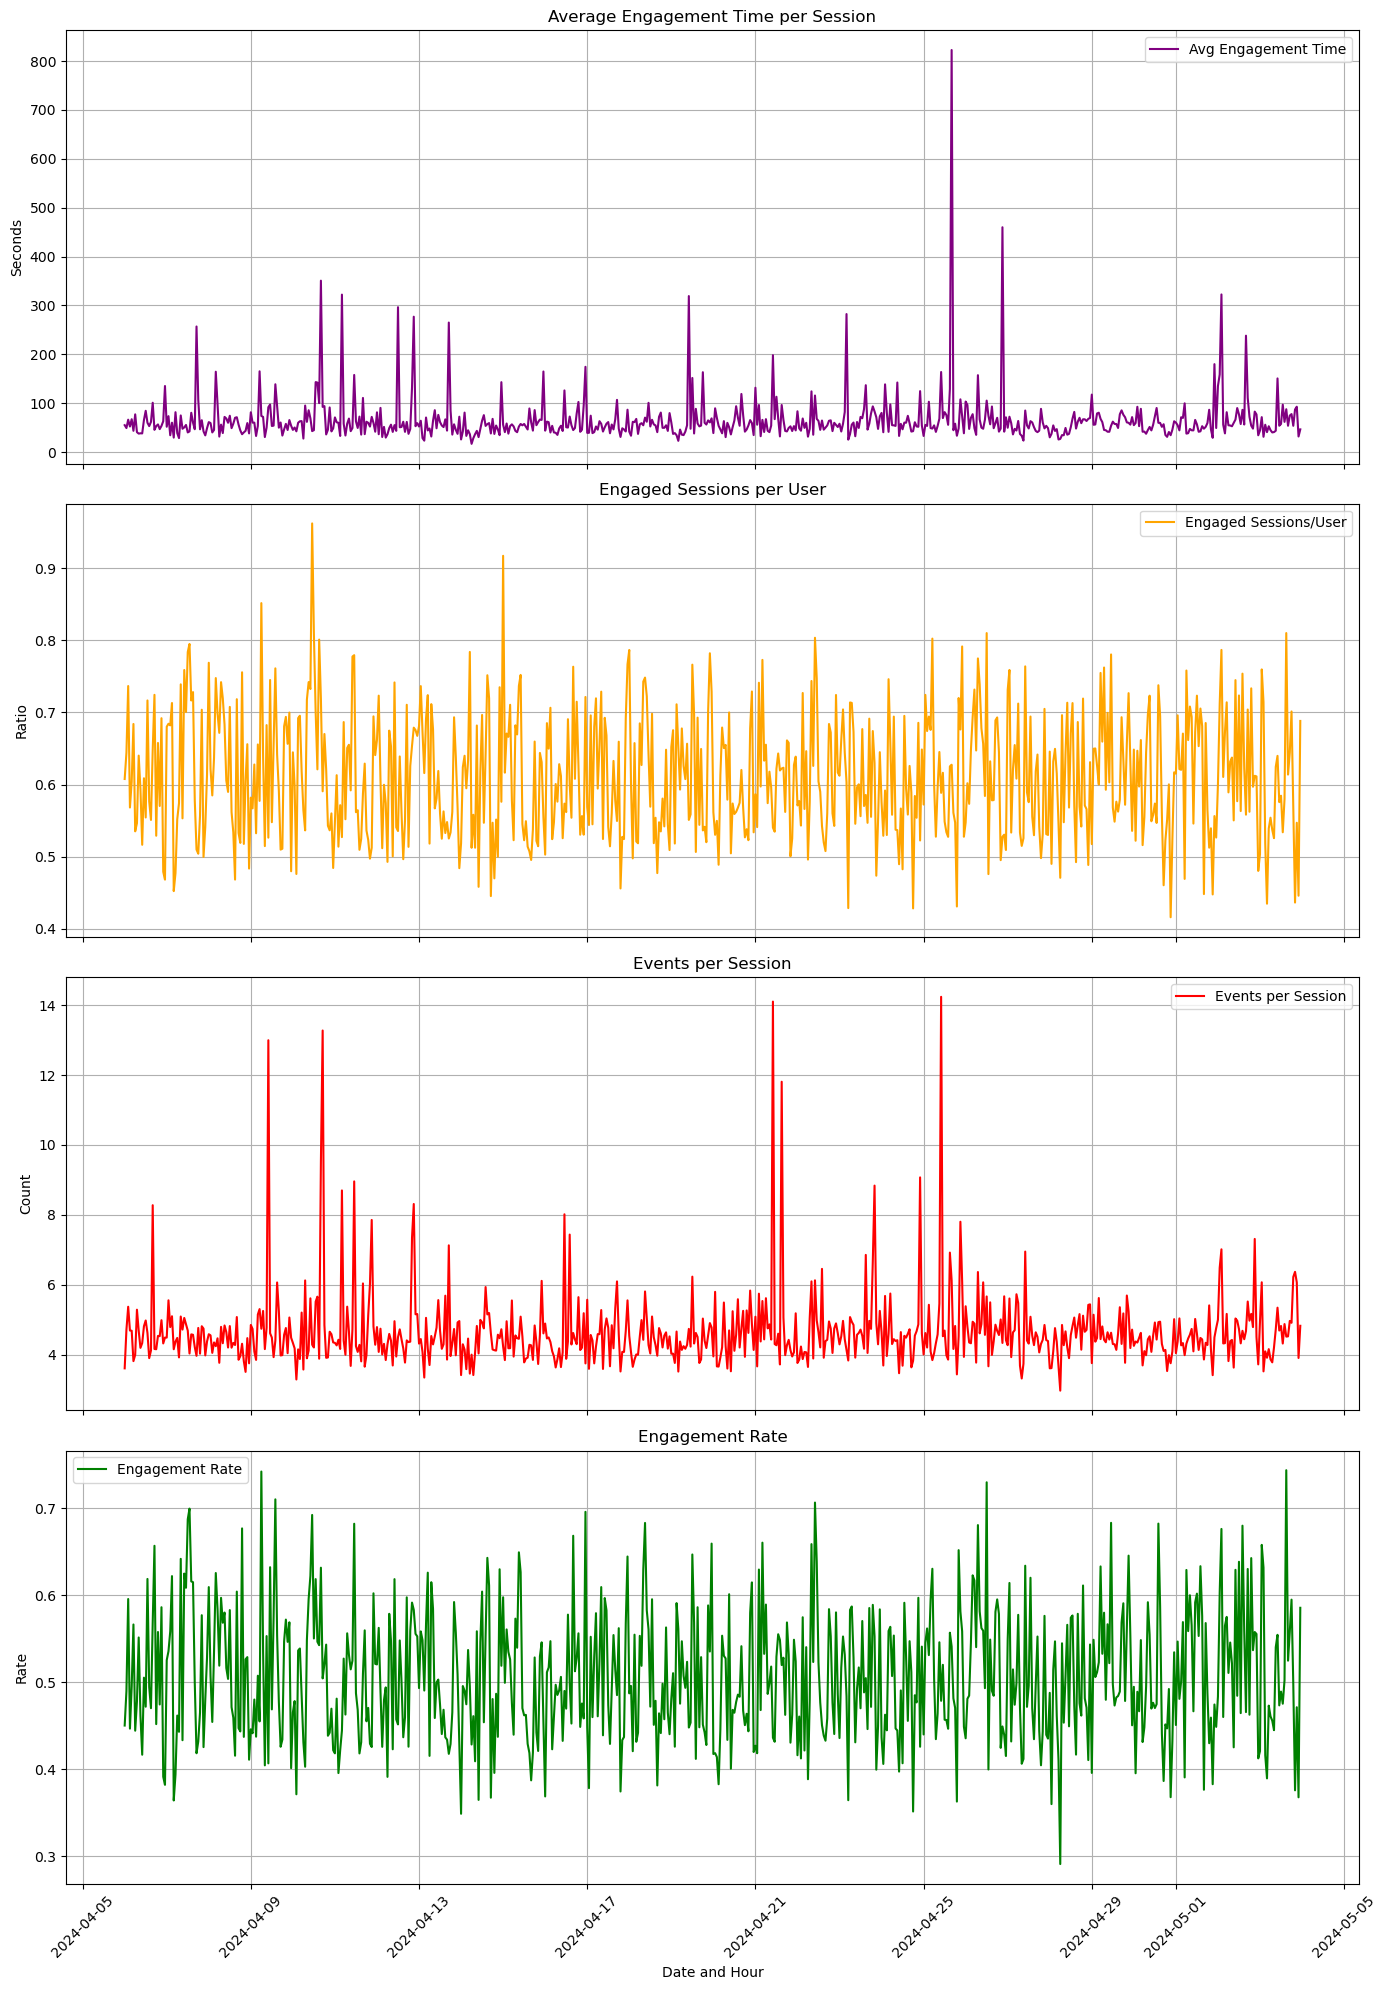

In [8]:
# Convert relevant columns to numeric for engagement analysis
numeric_columns = [
    'Engaged sessions',
    'Average engagement time per session',
    'Engaged sessions per user',
    'Events per session',
    'Engagement rate'
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle missing values
data.fillna(0, inplace=True)

# group data by date and calculate mean for engagement metrics
engagement_metrics = data.groupby(data['Date + hour (YYYYMMDDHH)']).agg({
    'Average engagement time per session': 'mean',
    'Engaged sessions per user': 'mean',
    'Events per session': 'mean',
    'Engagement rate': 'mean'
})

# Ensure index is in datetime format
engagement_metrics.index = pd.to_datetime(engagement_metrics.index)


# plotting engagement metrics
fig, ax = plt.subplots(4, 1, figsize=(14, 20), sharex=True)

ax[0].plot(engagement_metrics.index, engagement_metrics['Average engagement time per session'], label='Avg Engagement Time', color='purple')
ax[0].set_title('Average Engagement Time per Session')
ax[0].set_ylabel('Seconds')

ax[1].plot(engagement_metrics.index, engagement_metrics['Engaged sessions per user'], label='Engaged Sessions/User', color='orange')
ax[1].set_title('Engaged Sessions per User')
ax[1].set_ylabel('Ratio')

ax[2].plot(engagement_metrics.index, engagement_metrics['Events per session'], label='Events per Session', color='red')
ax[2].set_title('Events per Session')
ax[2].set_ylabel('Count')

ax[3].plot(engagement_metrics.index, engagement_metrics['Engagement rate'], label='Engagement Rate', color='green')
ax[3].set_title('Engagement Rate')
ax[3].set_ylabel('Rate')
ax[3].set_xlabel('Date and Hour')

for a in ax:
    a.legend()
    a.grid(True)
    a.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust spacing
plt.show()

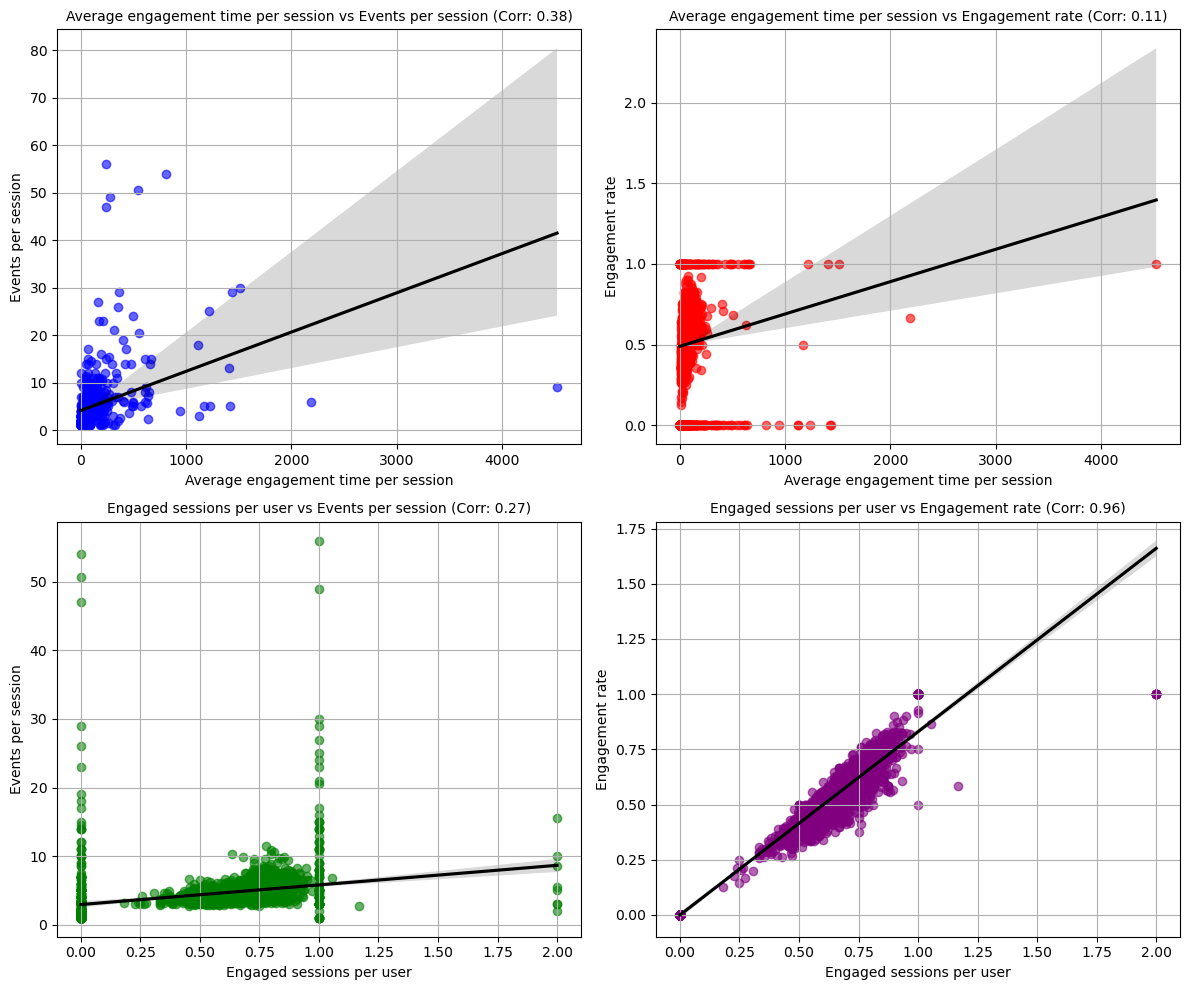

In [9]:
# ANALYZE THE CORRELATIONS BETWEEN THE ENGAGEMENT METRICS

# Ensure no missing values
data.fillna(0, inplace=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plots = [
    ('Average engagement time per session', 'Events per session', 'blue'),
    ('Average engagement time per session', 'Engagement rate', 'red'),
    ('Engaged sessions per user', 'Events per session', 'green'),
    ('Engaged sessions per user', 'Engagement rate', 'purple'),
]

# Iterate through each plot pair
for i, (x_col, y_col, color) in enumerate(plots):
    row, col = divmod(i, 2)
    x = data[x_col]
    y = data[y_col]
    
    # Scatter plot
    sns.regplot(ax=axes[row, col], x=x, y=y, scatter_kws={"color": color, "alpha": 0.6}, line_kws={"color": "black"})
    
    # Correlation coefficient
    corr, _ = pearsonr(x, y)
    
    # Titles and labels
    axes[row, col].set_title(f'{x_col} vs {y_col} (Corr: {corr:.2f})', fontsize=10)
    axes[row, col].set_xlabel(x_col)
    axes[row, col].set_ylabel(y_col)
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

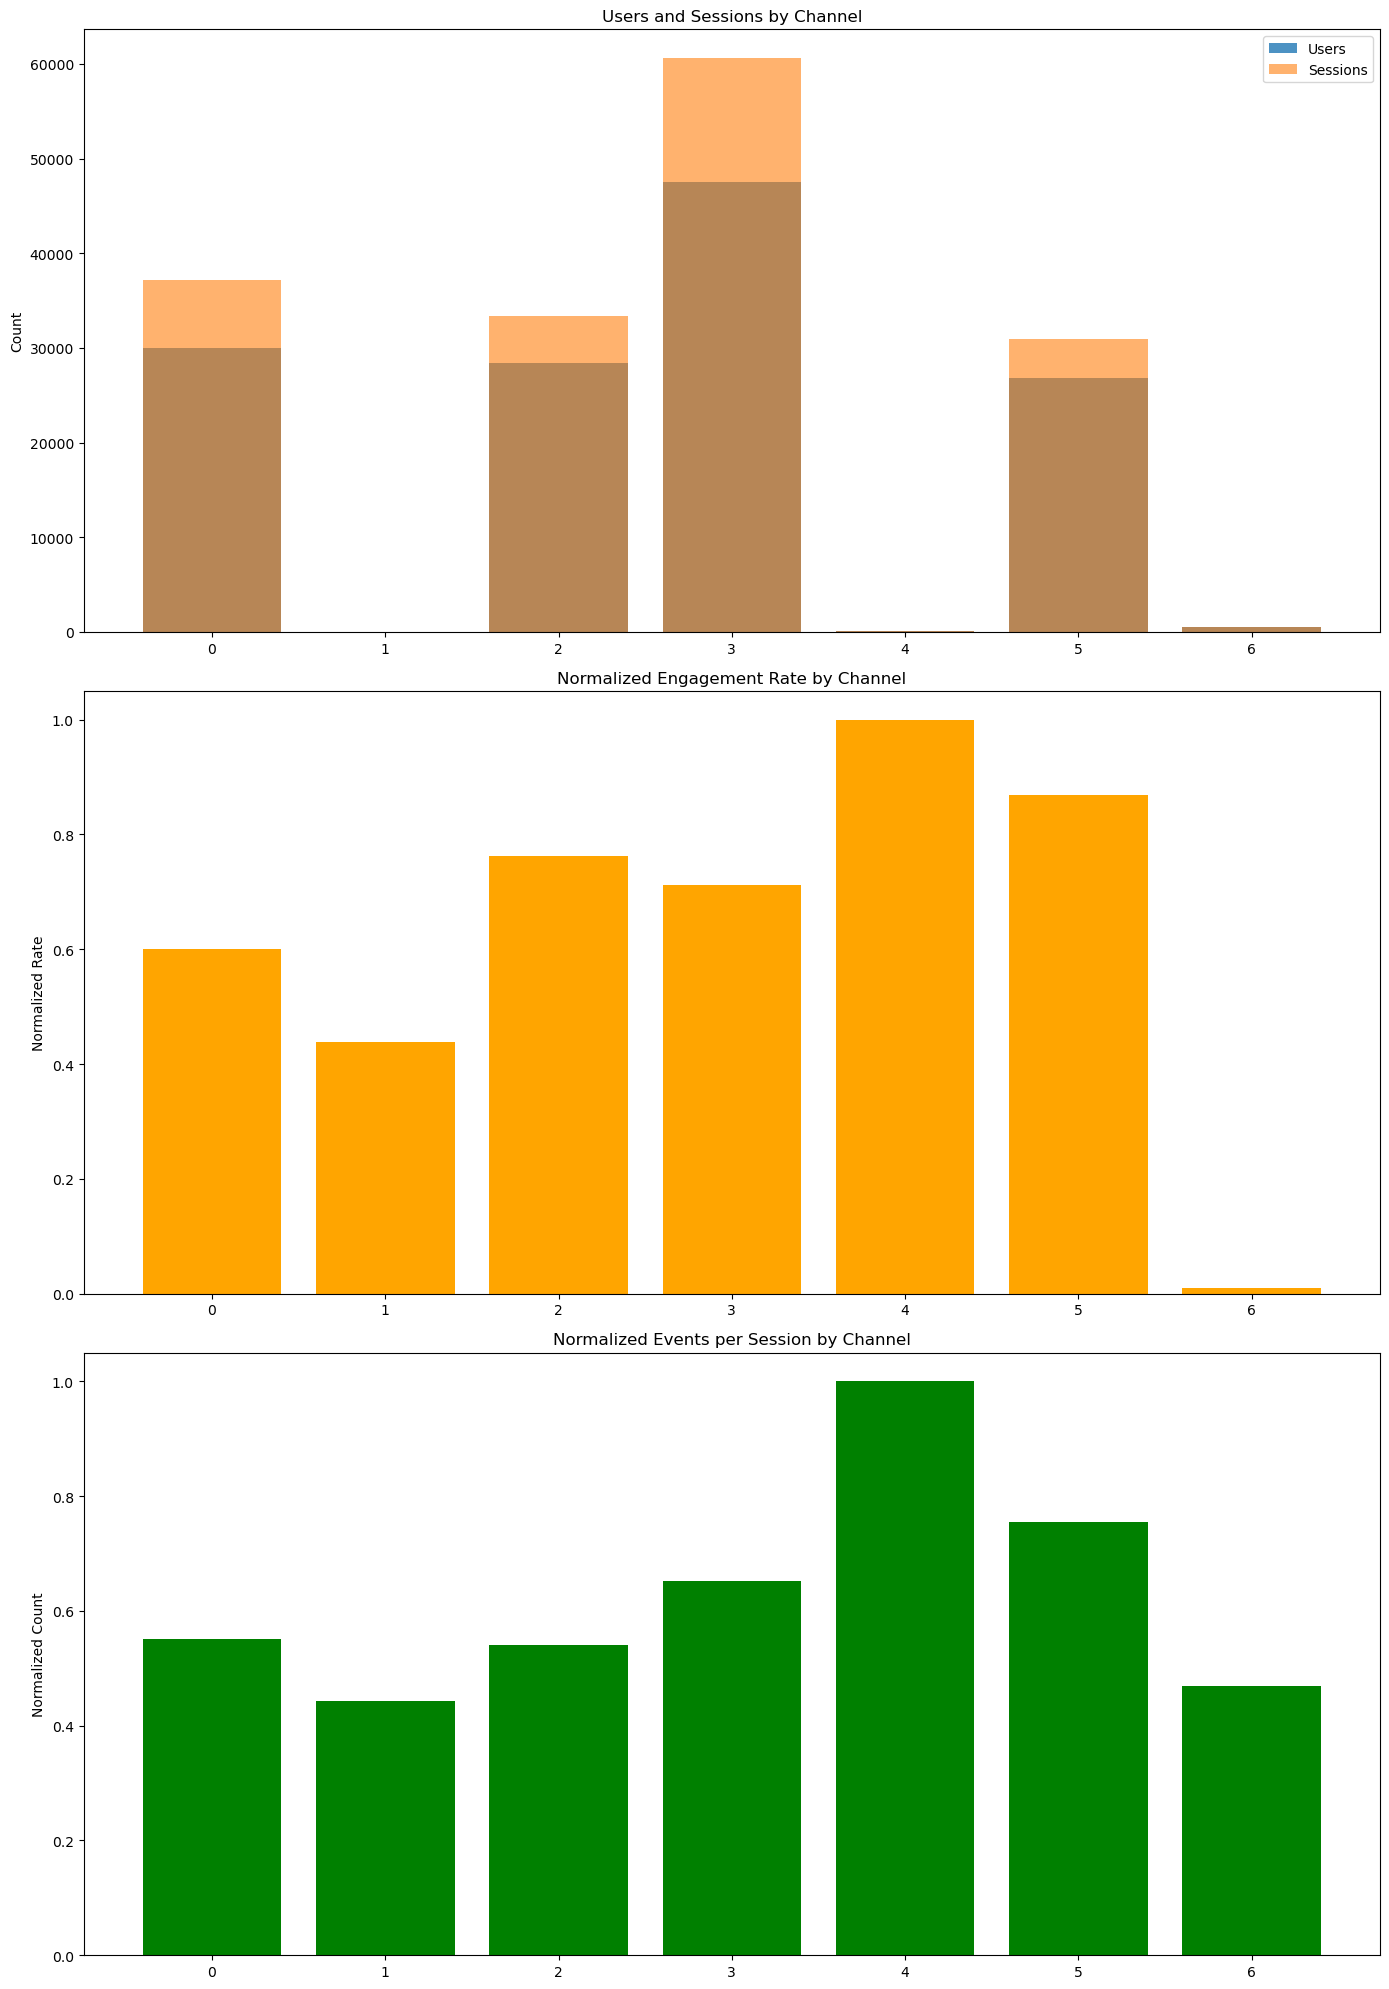

In [10]:
# PROCEED WITH THE CHANNEL PERFORMANCE ANALYSIS

# Validate required column
if 'Session primary channel group (Default channel group)' not in data.columns:
    raise KeyError("Required column 'Session primary channel group (Default channel group)' is missing.")

# Group data by channel and aggregate metrics
channel_performance = data.groupby('Session primary channel group (Default channel group)').agg({
    'Users': 'sum',
    'Sessions': 'sum',
    'Engaged sessions': 'sum',
    'Engagement rate': 'mean',
    'Events per session': 'mean'
}).reset_index()

# Normalize engagement rate and events per session for comparison
channel_performance['Normalized Engagement Rate'] = channel_performance['Engagement rate'] / channel_performance['Engagement rate'].max()
channel_performance['Normalized Events per Session'] = channel_performance['Events per session'] / channel_performance['Events per session'].max()

# Highlight the top 3 channels by users
top_channels = channel_performance.nlargest(3, 'Users')

# Plotting channel performance metrics
fig, ax = plt.subplots(3, 1, figsize=(14, 20))

# users and sessions by channel
ax[0].bar(channel_performance.index, channel_performance['Users'], label='Users', alpha=0.8)
ax[0].bar(channel_performance.index, channel_performance['Sessions'], label='Sessions', alpha=0.6)
ax[0].set_title('Users and Sessions by Channel')
ax[0].set_ylabel('Count')
ax[0].legend()

# normalized engagement rate by channel
ax[1].bar(channel_performance.index, channel_performance['Normalized Engagement Rate'], color='orange')
ax[1].set_title('Normalized Engagement Rate by Channel')
ax[1].set_ylabel('Normalized Rate')

# normalized events per session by channel
ax[2].bar(channel_performance.index, channel_performance['Normalized Events per Session'], color='green')
ax[2].set_title('Normalized Events per Session by Channel')
ax[2].set_ylabel('Normalized Count')

plt.tight_layout()
plt.show()

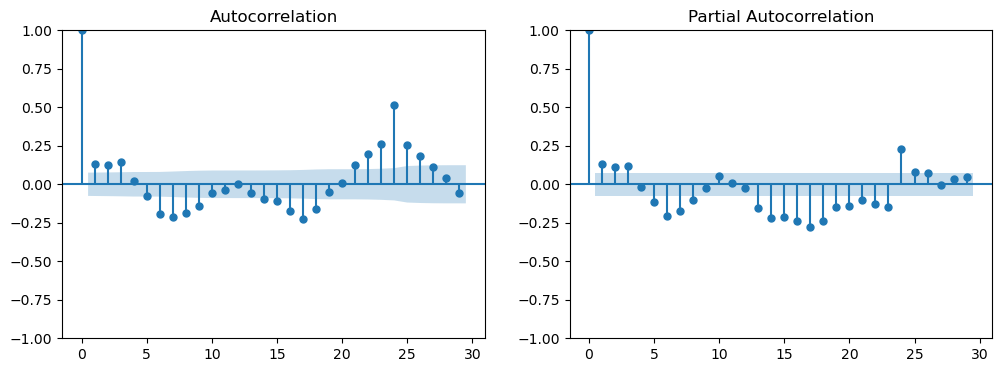

In [11]:
# Forecast website traffic with time series model
time_series_data = grouped_data['Sessions'].asfreq('h').ffill()
seasonal_period = 24

differenced_series = time_series_data.diff().dropna()

# plot ACF and PACF of time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

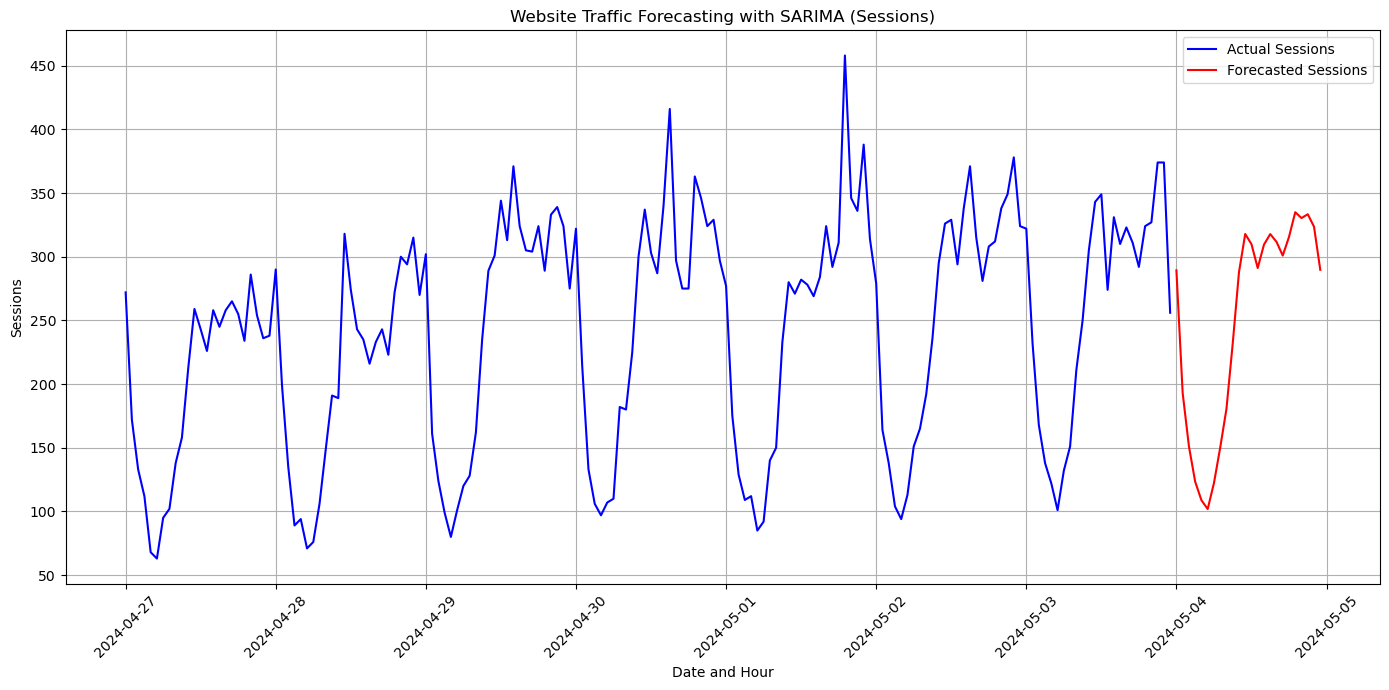

In [12]:
# forecast the website’s traffic for the next 24 hours using the SARIMA model

time_series_data = grouped_data['Sessions'].asfreq('h').ffill()
seasonal_period = 24


sarima_model = SARIMAX(time_series_data,
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, seasonal_period))
sarima_model_fit = sarima_model.fit()

# forecast the next 24 hours using the SARIMA model
sarima_forecast = sarima_model_fit.forecast(steps=24)

# plotting the actual data and the SARIMA forecast
plt.figure(figsize=(14, 7))
plt.plot(time_series_data.index[-168:], time_series_data[-168:], label='Actual Sessions', color='blue')  # last week data
plt.plot(pd.date_range(time_series_data.index[-1], periods=25, freq='h')[1:], sarima_forecast, label='Forecasted Sessions', color='red')
plt.title('Website Traffic Forecasting with SARIMA (Sessions)')
plt.xlabel('Date and Hour')
plt.ylabel('Sessions')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()